In [11]:
# Craig Phayer - 21340633
# Adam Collins - 21332967

# The code executes to the end without an error.

# Sources Cited:
# 

In [12]:
# Imports
import kagglehub
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image

In [13]:
# Dataset Link: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
# All images are 224 x 224 x 3 in jpg format and are cropped to ensure only the image of a single card is present and the card occupies well over 50% of the pixels in the image.

# Fetches the dataset from Kaggle and downloads it onto the local machine.
dataset_path = Path(kagglehub.dataset_download("gpiosenka/cards-image-datasetclassification"))

# Prints the location of the dataset, confirming the correct download path.
print("Path to dataset files:", dataset_path)

# Prints all items within the dataset path, providing an overview of the datasets structure.
# Prints all items within the dataset path, providing an overview of the datasets structure.
print("Contents of dataset_path:", list(dataset_path.iterdir()))

Path to dataset files: C:\Users\capri\.cache\kagglehub\datasets\gpiosenka\cards-image-datasetclassification\versions\2
Contents of dataset_path: [WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/14card types-14-(200 X 200)-94.61.h5'), WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/53cards-53-(200 X 200)-100.00.h5'), WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/cards.csv'), WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/test'), WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/train'), WindowsPath('C:/Users/capri/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2/valid')]


Total images loaded: 8154
Sample labels: ['ace of clubs', 'ace of clubs', 'ace of clubs', 'ace of clubs', 'ace of clubs']
Classes: ['test', 'train', 'valid']


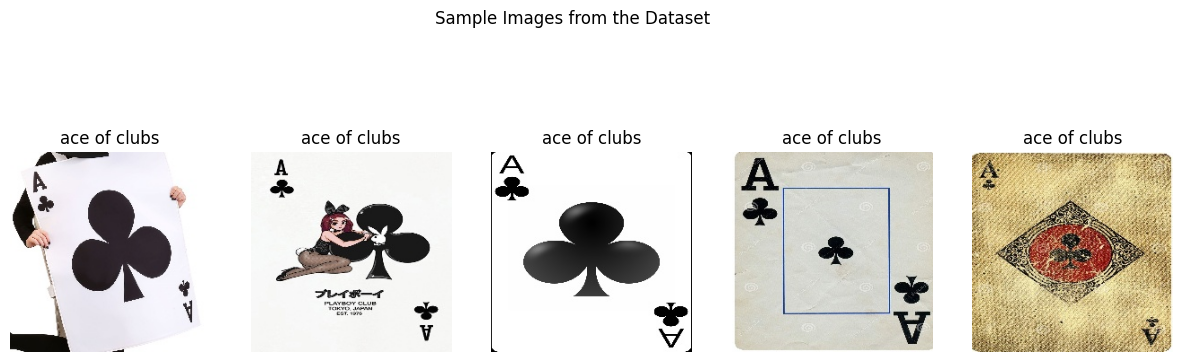

In [14]:
# Organising and checking the dataset.
# Prints sample images to confirm loading and labels.

# Empty lists used to store the file paths of images and their labels.
image_paths = []
labels = []

# Loop through train, test, and valid directories
for split in ['train', 'test', 'valid']:
    split_path = dataset_path / split
    for class_folder in split_path.iterdir():
        if class_folder.is_dir():
            # Assigns the folder name as the label.
            label = class_folder.name
            for img_file in class_folder.glob("*.jpg"):
                image_paths.append(img_file)
                labels.append(label)

# Prints total number of images loaded & displays first 5 labels.
print(f"Total images loaded: {len(image_paths)}")
print("Sample labels:", labels[:5])

# Collects the names of all folders within the dataset path that represent the different classes, and prints the list of class names.
class_names = [folder.name for folder in dataset_path.iterdir() if folder.is_dir()]
print("Classes:", class_names)

# Visualises a sample of the images.
def display_sample_images(num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle("Sample Images from the Dataset")

    for i in range(num_samples):
        image_path = image_paths[i]
        label = labels[i]

        image = Image.open(image_path)

        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis("off")

    plt.show()

display_sample_images(5)